<a href="https://colab.research.google.com/github/SilaWahome/SilaWahome/blob/main/SalesPredictor2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint




In [123]:
#IMPORT DATASET
df=pd.read_csv("/content/Sales Sample.csv")
df.head(10)

,Date,Qty,Sales
0,01/01/2021,1118,9506973
1,02/01/2021,377,9567913
2,03/01/2021,706,5810777
3,04/01/2021,647,3787331
4,05/01/2021,1540,1533492
5,06/01/2021,2069,3608636
6,07/01/2021,109,1441391
7,08/01/2021,1868,5791777
8,09/01/2021,2005,5063511
9,10/01/2021,2161,3897817


#   MODIFY YOUR DATASET

check for null values

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1461 non-null   object
 1   Qty     1461 non-null   int64 
 2   Sales   1461 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 34.4+ KB


Drop Qty

In [125]:
df.head(10)

,Date,Qty,Sales
0,01/01/2021,1118,9506973
1,02/01/2021,377,9567913
2,03/01/2021,706,5810777
3,04/01/2021,647,3787331
4,05/01/2021,1540,1533492
5,06/01/2021,2069,3608636
6,07/01/2021,109,1441391
7,08/01/2021,1868,5791777
8,09/01/2021,2005,5063511
9,10/01/2021,2161,3897817


convert date to datetime

In [126]:
df['Date']=pd.to_datetime(df['Date'])

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1461 non-null   datetime64[ns]
 1   Qty     1461 non-null   int64         
 2   Sales   1461 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 34.4 KB


CONVERT DATE TO A MONTHS PERIOD AND SUM THE NUMBER OF ITEMS IN EACH MONTH

In [128]:
df['Date']=df['Date'].dt.to_period('M')
monthly_sales=df.groupby('Date').sum().reset_index()

CONVERT THE NEW DATE TO TIME STAMP

In [129]:
monthly_sales['Date']=monthly_sales['Date'].dt.to_timestamp()

In [130]:
monthly_sales.head()

,Date,Qty,Sales
0,2021-01-01,36335,152115623
1,2021-02-01,35160,151910229
2,2021-03-01,40619,183353327
3,2021-04-01,39167,133137647
4,2021-05-01,45852,163689339


In [131]:
#ADD A VISUALIZATION FOR THAT

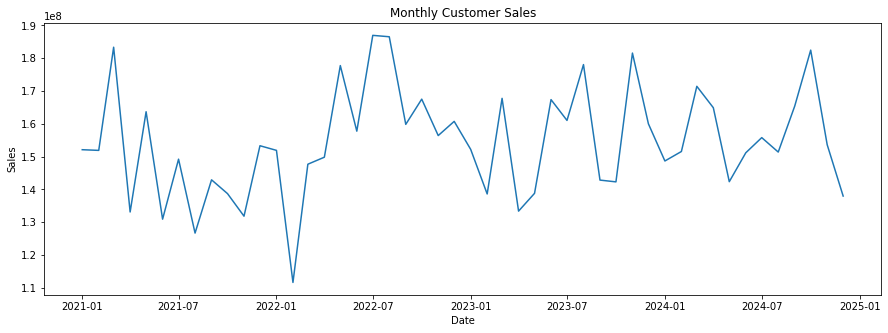

In [132]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Date'],monthly_sales['Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("Monthly Customer Sales")
plt.show()

Get Difference on Sales to make stationary sales data

In [133]:
monthly_sales['sales_diff']=monthly_sales['Sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,Date,Qty,Sales,sales_diff
1,2021-02-01,35160,151910229,-205394.0
2,2021-03-01,40619,183353327,31443098.0
3,2021-04-01,39167,133137647,-50215680.0
4,2021-05-01,45852,163689339,30551692.0
5,2021-06-01,39877,130949313,-32740026.0
6,2021-07-01,33261,149230971,18281658.0
7,2021-08-01,45763,126705616,-22525355.0
8,2021-09-01,38762,142936629,16231013.0
9,2021-10-01,41689,138733380,-4203249.0
10,2021-11-01,38657,131858557,-6874823.0


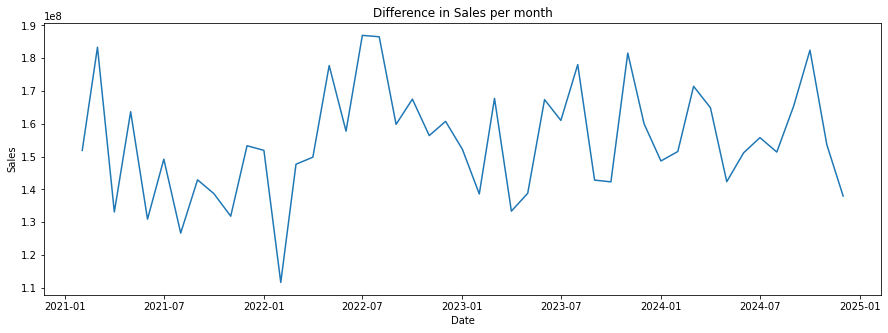

In [134]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Date'],monthly_sales['Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Difference in Sales per month')
plt.show()

PREPARE A MODEL FOR PREDICTING SALES IN THE NEXT MONTHS

In [135]:
supervised_data=monthly_sales.drop(['Date','Sales'],axis=1)

PREPARING THE SUPERVISED DATA

# GETTING ANALYTICAL WITH YOUR DATA: DATA REENGINEERING

In [136]:
for i in range(1,-14):
  col_name='month_' + str(i)
  supervised_data[col_name]=supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,Qty,sales_diff
0,35160,-205394.0
1,40619,31443098.0
2,39167,-50215680.0
3,45852,30551692.0
4,39877,-32740026.0
5,33261,18281658.0
6,45763,-22525355.0
7,38762,16231013.0
8,41689,-4203249.0
9,38657,-6874823.0


SPLIT THE DATA INTO TRAIN AND TEST

In [137]:
train_data =supervised_data[:12]
test_data =supervised_data[-12:]
print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (12, 2)
Test Data Shape:  (12, 2)


In [138]:
scaler=MinMaxScaler(feature_range=(-1,1)) 
scaler.fit(train_data) 
test_data = scaler.transform(test_data)
train_data = scaler.transform(train_data)

In [139]:
x_train,y_train=train_data[:,1:],train_data[:,0] 
x_test,y_test=test_data[:,1:],test_data[:,-2:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("x_train Shape: ",x_train.shape)
print("y_train Shape: ",y_train.shape)
print("x_test Shape: ",x_test.shape)
print("y_test Shape: ",y_test.shape)

x_train Shape:  (12, 1)
y_train Shape:  (12,)
x_test Shape:  (12, 1)
y_test Shape:  (12,)


ADD PREDICTION DATA FRAME TO MERGE SALES PRICES OF ALG

In [140]:
act_sales=monthly_sales['Sales'][-33:].to_list()
print(act_sales)

[149831159, 177753518, 157767460, 186966827, 186539266, 159841132, 167530159, 156427047, 160752912, 152218884, 138628962, 167769061, 133401360, 138817724, 167381616, 161044081, 178058194, 142853583, 142315724, 181569931, 160010155, 148680687, 151569876, 171433968, 164911088, 142372048, 151172861, 155799719, 151400202, 165415546, 182467442, 153633451, 137990734]


In [141]:
sales_dates=monthly_sales['Date'][-14:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

FIND A LINEAR RELATIONSHIP and Predicted Outputs

# Adding Linear Regression to start Predictions

In [142]:
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre =lr_model.predict(x_test)




In [143]:
lr_pre =lr_pre.reshape(-1,1)
lr_pre_test_set =np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set= scaler.inverse_transform(lr_pre_test_set)

In [144]:
result_list=[]
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series=pd.Series(result_list,name="Linear Prediction")
predict_df =predict_df.merge(lr_pre_series,left_index=True,right_index=True)

In [145]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['Sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['Sales'][-12:])
lr_r2= r2_score(predict_df['Linear Prediction'],monthly_sales['Sales'][-12:])
print("Linear Regression MSE:",lr_mse)
print("Linear Regression MAE: ",lr_mae)
print("Linear Regression R2: ",lr_r2)

Linear Regression MSE: 21610865.970514838
Linear Regression MAE:  17708648.36763263
Linear Regression R2:  -1.379139013799974


In [146]:
#VISUALIZATION OF THE ACTUAL VS PREDICTED

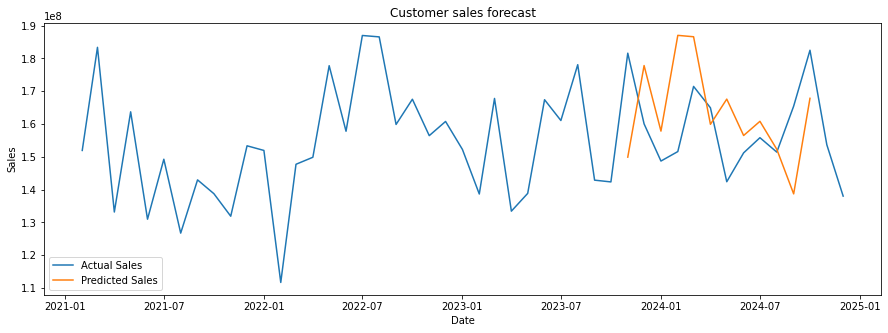

In [176]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Date'],monthly_sales['Sales'])
plt.plot(predict_df['Date'],predict_df['Linear Prediction'])
plt.title("Customer sales forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()